# Regularization and Polynomial Regression
This notebook walks through the basics of regularization and polynomial regression

In [1]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
from sklearn import linear_model
import numpy as np

# Regularization in Regression

First up, let's revisit this [example plot of ridge regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

Automatically created module for IPython interactive environment


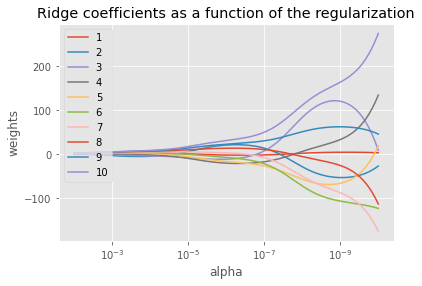

In [3]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(range(1,len(coefs)), loc="upper left") # <<<< added this line here
plt.axis('tight')
plt.show()

This plot looks nice, but it doesn't actually label which coefficient corresponds to which color!  It's not useful as a diagnostic tool.

Let's try a more grounded analysis.  We'll look at an analysis of diabetes patients, using some of their 

In [4]:
dat = pd.read_csv("../data/diabetes.csv")
dat

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


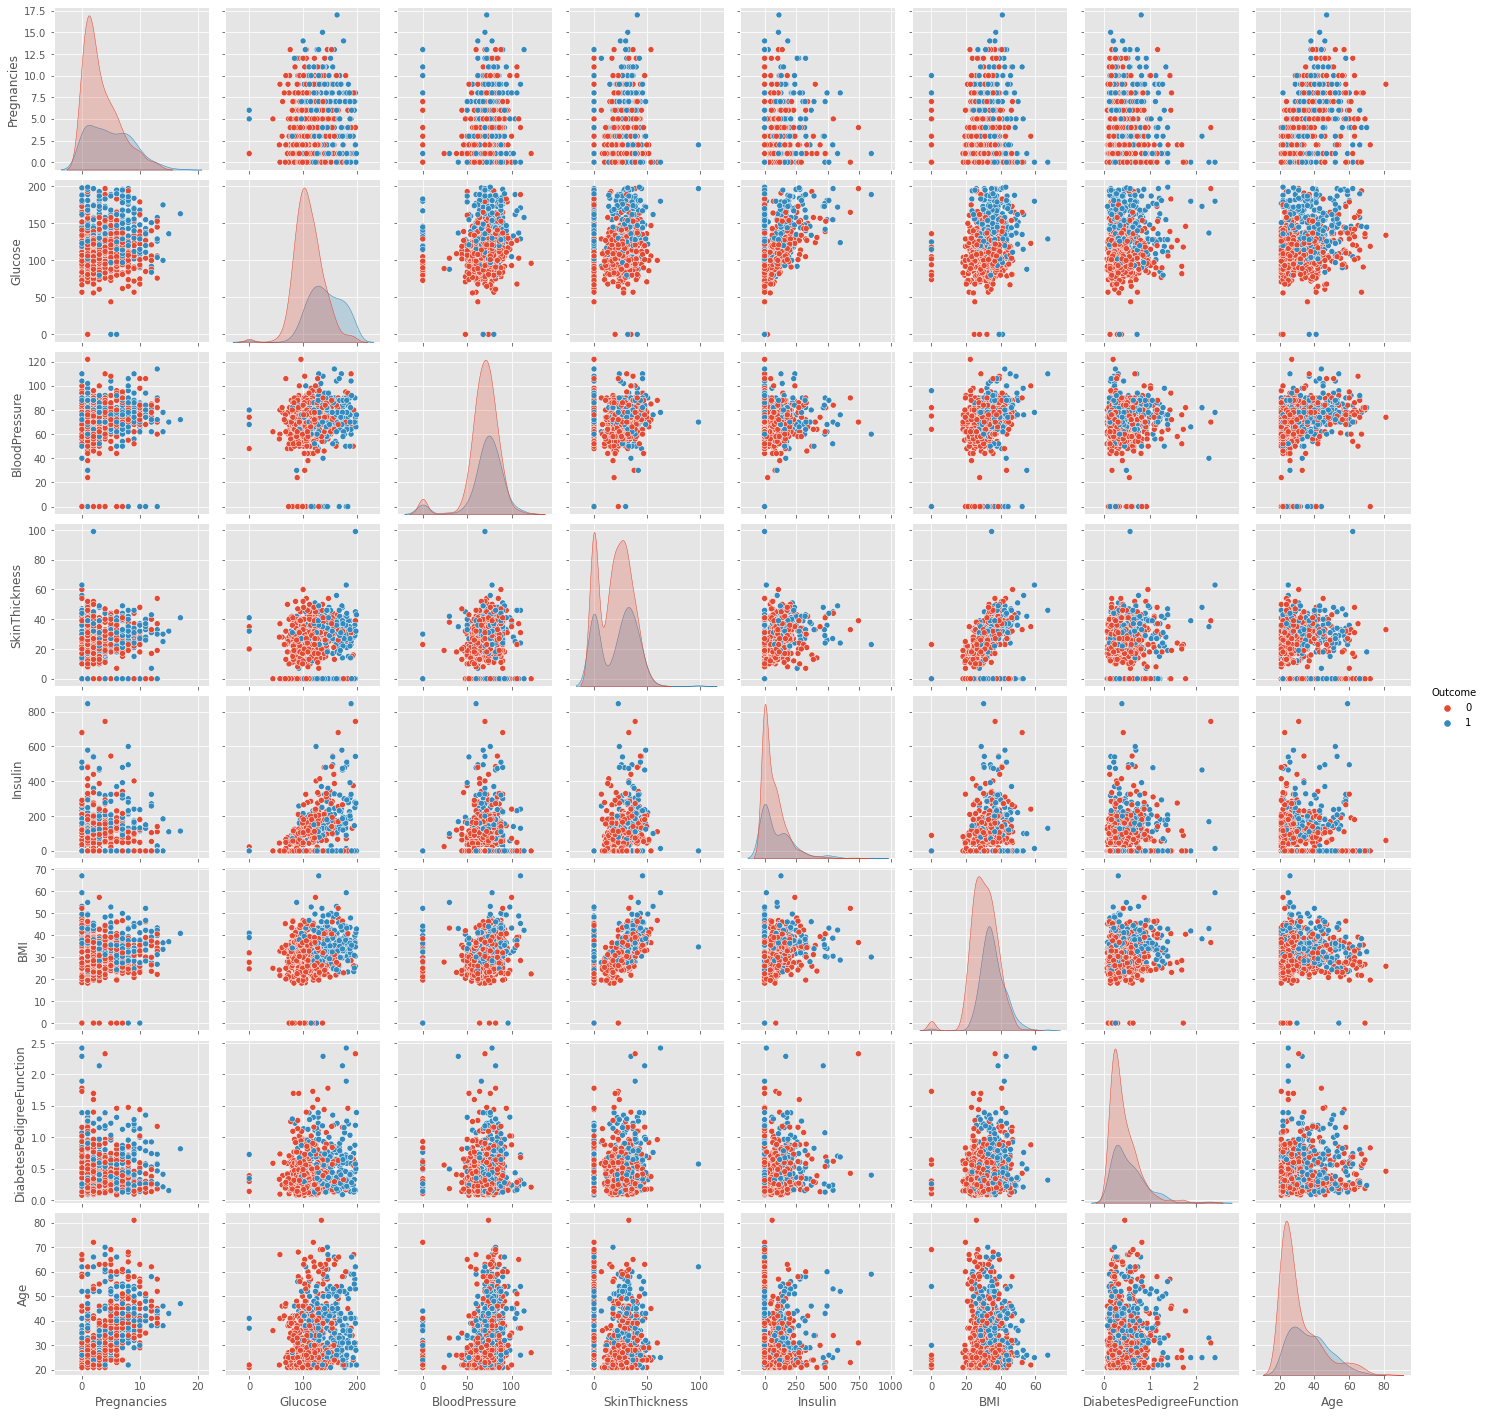

In [5]:
sns.pairplot(dat,hue="Outcome");

We'll set up our training data.  I noticed that "DiabetesPedigreeFunction" is a very strong signal.  In fact, it's so strong it drowns out the rest of the features!  Let's try to model diabetes probability without it.

In [6]:
X = dat.drop(["Outcome", "DiabetesPedigreeFunction"], axis=1)
y = dat.Outcome
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [7]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, solver='lbfgs', max_iter=500)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=0)

In [8]:
import numpy as np

y_pred = classifier.predict(X_test)
probs_y=classifier.predict_proba(X_test)
probs_y = np.round(probs_y, 2)

We can inspect the coefficients by binding them to their names:

In [9]:
pd.DataFrame(classifier.coef_, columns=X.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
0,0.080945,0.032964,-0.011296,0.007285,-0.000781,0.090041,0.024092


We can compare them a bit more easily by plotting them:

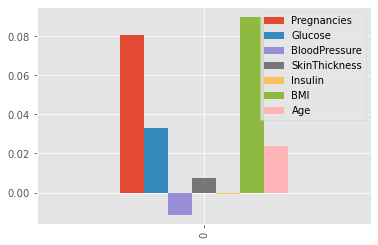

In [10]:
pd.DataFrame(classifier.coef_, columns=X.columns).plot.bar();

We can look at their correlations with a simple correlation plot.  The gradient map here is blue (for low correlation) to red (for high correlation).  We can see that most of the features here are correlated only with eachother, except for maybe Age/Pregnancies.

In [11]:
X.corr().style.background_gradient(cmap="coolwarm")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.036242
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,1.000000


Let's regularize using ridge regression, and use GridSearchCV to do cross validation and grid search.

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
ridge= GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=10 )

In [13]:
print('The optimal alpha is:',ridge.fit(X,y).best_params_)
# Printing the average neg_mean_squared_error of a 10-fold cross validation
print('The score for the best Ridge alpha is:',ridge.fit(X,y).best_score_)


The optimal alpha is: {'alpha': 100}
The score for the best Ridge alpha is: -0.16455649238838513


In [14]:
best_ridge_model= Ridge(alpha=10)
best_ridge_model.fit(X,y)

Ridge(alpha=10)

In [15]:
pd.DataFrame([best_ridge_model.coef_], columns=X.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
0,0.019674,0.006042,-0.002408,0.00053,-0.000141,0.013633,0.002911


We can compare the coefficients between the best ridge model, and original classifier model:

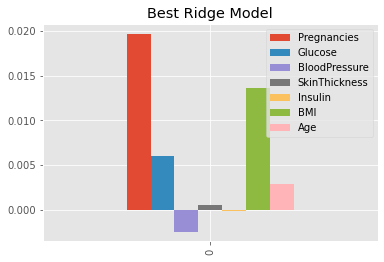

In [16]:
pd.DataFrame([best_ridge_model.coef_], columns=X.columns).plot.bar(title="Best Ridge Model");

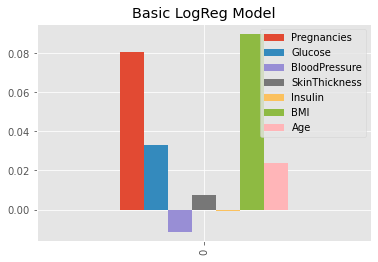

In [17]:
pd.DataFrame(classifier.coef_, columns=X.columns).plot.bar(title="Basic LogReg Model");

We can compare the metrics between the best ridge model and the basic classifier below:

In [18]:
from sklearn.metrics import accuracy_score
print("Logistic Regression Accuracy")
accuracy_score(y_test, classifier.predict(X_test))

Logistic Regression Accuracy


0.796875

In [19]:
print("Best Ridge Regression Model Accuracy")
accuracy_score(y_test, best_ridge_model.predict(X_test) > .50)

Best Ridge Regression Model Accuracy


0.8020833333333334

Not much of an improvement, but we're able to remove some additional fields this way if we wish (SkinThickness and Insulin)

# Feature Engineering

Is there a way we can improve the regularized model even further?  We know that linear models don't work well if the target class is not linear separable.  Can we try and create a *new* distribution that tries to linearize the target variable a bit better?

In [20]:
def isextreme(series, stddev=1):
    return ((series - series.mean())/series.std()).abs() > stddev

In [21]:
dat["ExtremeGlucose"] = dat.Glucose > 150
dat["ExtremePregnancies"] = isextreme(dat.Pregnancies,1)
dat["ExtremeSkinThickness"] = isextreme(dat.SkinThickness,1)
dat["HighRiskAge"] = (dat.Age > 40) & (dat.Age < 60)

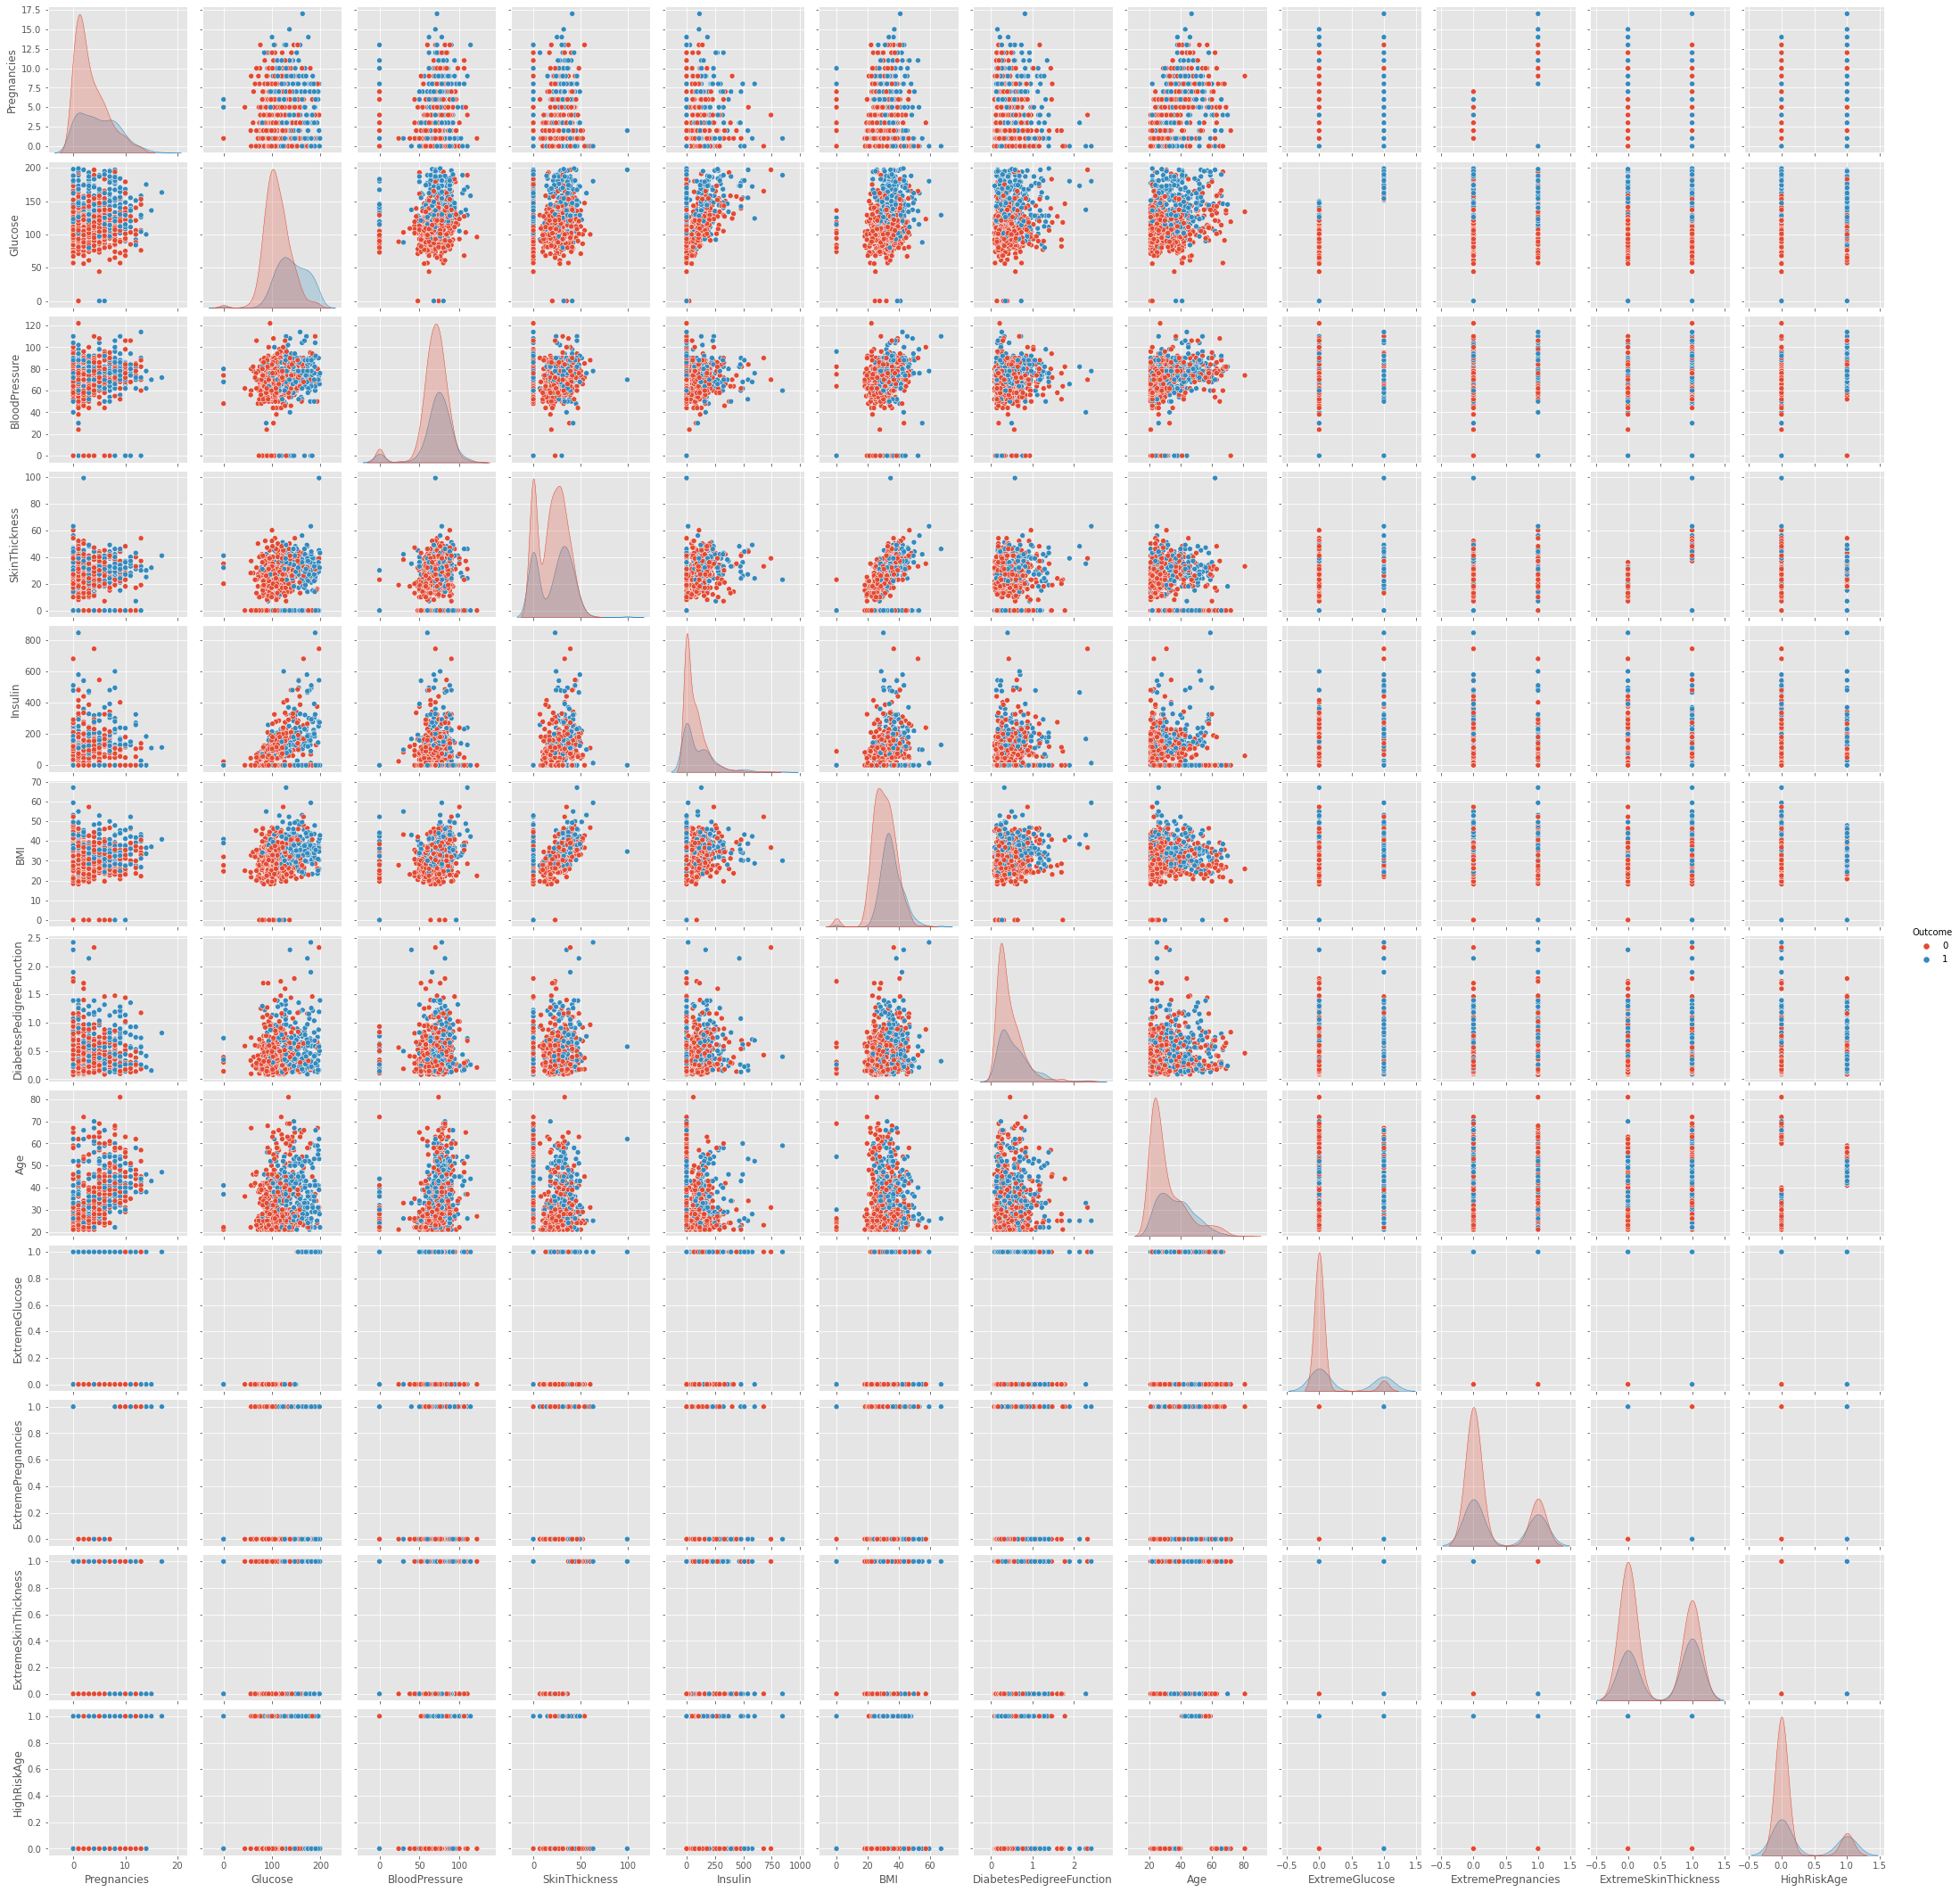

In [22]:
sns.pairplot(dat,hue="Outcome");

In [23]:
X = dat.drop(["Outcome", "DiabetesPedigreeFunction"], axis=1)
y = dat.Outcome
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
ridge= GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=10 )

print('The optimal alpha is:',ridge.fit(X,y).best_params_)
# Printing the average neg_mean_squared_error of a 10-fold cross validation
print('The score for the best Ridge alpha is:',ridge.fit(X,y).best_score_)

The optimal alpha is: {'alpha': 50}
The score for the best Ridge alpha is: -0.16330132987237783


In [25]:
best_ridge_model= Ridge(alpha=50)
best_ridge_model.fit(X,y)

Ridge(alpha=50)

In [26]:
pd.DataFrame([best_ridge_model.coef_], columns=X.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,ExtremeGlucose,ExtremePregnancies,ExtremeSkinThickness,HighRiskAge
0,0.016101,0.005573,-0.002437,0.000661,-0.000147,0.012765,0.00134,0.056088,0.033952,0.009568,0.085396


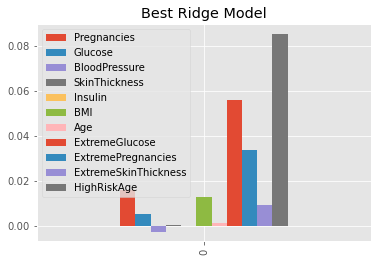

In [27]:
pd.DataFrame([best_ridge_model.coef_], columns=X.columns).plot.bar(title="Best Ridge Model");

In [28]:
accuracy_score(y_test, best_ridge_model.predict(X_test) > .50)

0.8125

We squeezed one more point of accuracy this way for not much trouble.  We also found a way to get some more predictive power from some features that were not that useful before (skin thickness).  In general, if you see that your target value distribution is skewed or biased somehow in the non-target distribution, try to think of a way to isolate or linearly separate the target values from the non-target values.  Nonlinear model does this automatically, but well grounded decisions on which transformations make sense are always preferred.

# Polynomial Regression

Polynomial regression attempts to model a distribution by means of a polynomial function.  Rather than performing multiple regression with multiple simple linear models, polynomial regression regresses against the coefficients of its degree.

Here's some example data... it's not *quite* linear, but it looks like there's some correlation there.

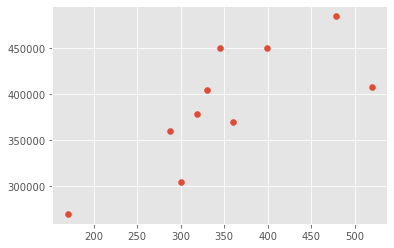

In [29]:
import pandas as pd
import numpy as np
xdic={'X': {11: 300, 12: 170, 13: 288, 14: 360, 15: 319, 16: 330, 17: 520, 18: 345, 19: 399, 20: 479}}
ydic={'y': {11: 305000, 12: 270000, 13: 360000, 14: 370000, 15: 379000, 16: 405000, 17: 407500, 18: 450000, 19: 450000, 20: 485000}}
X=pd.DataFrame.from_dict(xdic)
y=pd.DataFrame.from_dict(ydic)
plt.scatter(X,y);

We can try to fit the data with a polynomial curve.  We see that the model looks to do a fairly good job of passing closely to all the points.  But... the polynomial often overfits the *extremes* of the distribution.  Look at the far edges of this scatterplot, do you think that the distribution will continue to increase or decrease (respectively) from the left and right edge?

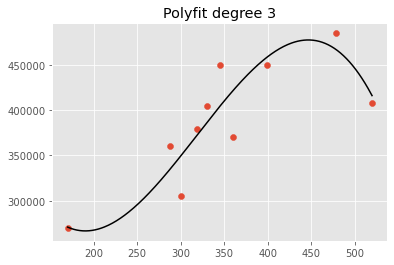

In [30]:
degree = 3
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
coefs = np.polyfit(X.values.flatten(), y.values.flatten(), degree)
plt.figure()
plt.plot(X_seq, np.polyval(coefs, X_seq), color="black")
plt.title("Polyfit degree "+str(degree))
plt.scatter(X,y)
plt.show();

This behavior can become even more apparent when the degree of the polynomial grows too large.  There's only a very low probability that more examples from this distribution will follow the polynomial curve here:

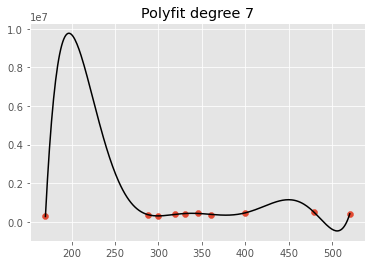

In [31]:
degree = 7
X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
coefs = np.polyfit(X.values.flatten(), y.values.flatten(), degree)
plt.figure()
plt.plot(X_seq, np.polyval(coefs, X_seq), color="black")
plt.title("Polyfit degree "+str(degree))
plt.scatter(X,y)
plt.show();

In summary, the choice of a polynomial function (or any curve fitting function) must be firmly grounded in the *domain knowledge* of the data.  E.g. is it a survival curve?  A growth curve?  A log normal?  If you can answer this question authoritatively, consider curve fitting functions for your modeling.

# More on Mathematical Curve Fitting



1. [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://www.semanticscholar.org/paper/Emergence-of-simple-cell-receptive-field-properties-Olshausen-Field/8012c4a1e2ca663f1a04e80cbb19631a00cbab27)
2. [Efficient Audio Coding](http://www-labs.iro.umontreal.ca/~pift6080/H08/documents/papers/SmithLewickiNatureFeb06.pdf)

Also, just wanted to reference [this tweet](https://twitter.com/WhiteHouseCEA45/status/1257680258364555264) in case someone wanted to see it again... :)
